In [1]:
import numpy as np
import copy
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl

# Synthetic Datapoints to test the EM algorithm while building

In [175]:
n=100 #number of points
d=2 #dimension of each point
k=2 #clusters

#randomly generate k number of  d-dimensional means
mus=np.random.random((k,d))*20-10 

#Data Generation
X=[]
for i in range(n):
    for j in range(k):
        X.append([mean+np.random.randn() for mean in mus[j]])
#we have our dataset, where each point is a d+1 dimensional tuple where the last position represents its class 

X = np.asarray(X)

# EM Algorithm

In [7]:
def EM(X,k):

    #dimension of the dataset
    d = X.shape[1]

    #number of points in the dataset
    n = X.shape[0]

    '''initialising means ---------------------------------'''
    # random means
    # old_mus = np.array([np.random.rand(d) for _ in range(k)])

    # select random datapoints from data as initial means
    random_rows = np.random.choice(X.shape[0], size=k, replace=False)
    old_mus = copy.deepcopy(X[random_rows, :])

    # choose means from unifrom random between 'a' and 'b' 
    # old_mus = np.random.random((k,d))*20-10 
    # old_mus = np.random.random((k,d))*np.max(X)-np.min(X)


    new_mus = copy.deepcopy(old_mus)
    # print('original',mus)
    # print("initial", new_mus)
    '''-------------------------------------------------------'''


    '''initalising covariance matrices-------------------------'''
    #identity matrices of dxd dimension as covariance matrices
    old_cov = np.asarray([np.eye(d) for _ in range(k)])
    new_cov = copy.deepcopy(old_cov)
    '''-------------------------------------------------------'''

    '''initialising priors-------------------------------------'''
    #priors are 1/k where k is the number of classes
    old_priors = np.full((k),1/k)
    new_priors = copy.deepcopy(old_priors)
    '''-------------------------------------------------------'''

    #stopping condition
    eps = 1e-02

    #starting time
    t = 0

    #aritifcal condition to enter the loop
    obt_eps = 1

    while (obt_eps > eps) or (t==0):
        t += 1

        '''Begin Expectation step---------------------------------------------------------'''
        #get the W matrix
        #unnormalised
        # W_temp = copy.deepcopy(tabulate(list(range(n)),list(range(k)),w_mat))
        # W_temp = np.array(list(map(w_mat, * np.meshgrid(list(range(n)), list(range(k))))))
        W_temp = np.zeros((k,n),dtype=float)
        for j in range(k):
            W_temp[j,:]= multivariate_normal.pdf(X,mean=new_mus[j],cov=new_cov[j],allow_singular=True) * new_priors[j]

        temp = copy.deepcopy(W_temp)
        #normalised
        W = copy.deepcopy(temp/temp.sum(axis=0))

        #it so happens that sometime, the probability of a point being assinged to any of the cluster is 0.
        #this is probably an artefact of multivariate.normal.pdf giving very small values 
        # and the 64 bit precision of the computer rounding stuff off to 0 or nan. 
        #When this happens, this part of the assigns the point to any of the clusters with equal probability.
        if np.isfinite(W).all():
            pass
        else:
            W_temp_where = np.where(temp.sum(axis=0)==0.0)
            for ii in W_temp_where:
                W[:,ii] = 1/k
        '''End Expectation step------------------------------------------------------------'''

        #get sum of W for each cluster
        temp = copy.deepcopy(W)
        sum_w = copy.deepcopy(temp.sum(axis=1))

        '''Begin Maximization step---------------------------------------------------------'''
        # re-estimate means
        old_mus = copy.deepcopy(new_mus)
        #unnormalised
        new_mus_temp = copy.deepcopy(W @ X)
        temp = copy.deepcopy(new_mus_temp)
        #normalised
        new_mus = copy.deepcopy(temp/sum_w[:,None])

        # re-estimate covariance
        old_cov = copy.deepcopy(new_cov)
        #unnormalised
        # new_cov_temp = copy.deepcopy([cov_loop(n,a) for a in range(k)])
        # temp = copy.deepcopy(new_cov_temp)
        #normalised
        # new_cov = copy.deepcopy([temp[a]/sum_w[a] for a in range(k)])
        new_cov = [
                    np.sum(
                            [
                                W[i,j]/(sum_w[i])*
                                (
                                    (np.expand_dims(X[j]-new_mus[i], axis=0).T) @ 
                                    np.expand_dims(X[j]-new_mus[i], axis=0)
                                ) 
                                for j in range(n)
                            ],axis=0
                        ) 
                        for i in range(k)
                     ]
        # new_cov = copy.deepcopy([cov_loop(n,a) for a in range(k)])



        # re-estimate priors
        old_priors = copy.deepcopy(new_priors)
        new_priors = copy.deepcopy(sum_w/n)
        '''End Maximization step---------------------------------------------------------'''

        obt_eps = np.sum([np.linalg.norm(new_mus[a]-old_mus[a]) for a in range(k)])
        print(obt_eps)
    # print("final", t,n,k,d,new_mus) 
    return W,new_mus,new_cov,t


# Ringnorm analysis

In [18]:
# Loading data
# \s+ since dataset has one or more white spaces
df = pd.read_csv("Dataset.data",sep='\s+',header=None)

X = df.to_numpy()
X = X[:,:-1]

mus = np.asarray(
    [ [0]*X.shape[1],
        [2/np.sqrt(20)]*X.shape[1]
        ]
)

In [ ]:
#20 runs

posteriors,output_mus,output_covs,iterations = {},{},{},{}

for k in [2,3,4,5]:
    data = {}
    for e in range(20):
        print(f"k={k},e={e}")
        p,m,c,i = EM(X,k)
        posteriors[e] = p
        output_mus[e] = m
        output_covs[e] = c
        iterations[e] = i
    data['posteriors'] = posteriors
    data['output_mus'] = output_mus
    data['output_covs'] = output_covs
    data['iterations'] = iterations
    with open(f"ringnorm{k}.pkl",'wb') as f:
        pkl.dump(data,f)
        

In [26]:
#single run
posterior,new_means,_,_ = EM(X,4)

16.988561267643487
2.084049027870727
1.3555884528186957
5.6117000783326825
1.6169301710044943
0.5160197540746403
0.31154283935589117
0.23446864788798252
0.20972693049634236
0.21712753959982284
0.2102745825699932
0.17277972942886038
0.15479391889605887
0.14669948274083583
0.15134675025917832
0.14805065003977214
0.1486757210743646
0.1483567719435972
0.14513833786888608
0.1366289532612258
0.13444317006724377
0.12804301986315422
0.1140461410366515
0.09717703281002826
0.08403074315710604
0.07667659344162367
0.07364992300135945
0.07314409209812599
0.07452421946122115
0.07700316521956278
0.07819799131910364
0.07671034105907835
0.07508426983675628
0.07301157883199745
0.07024072318953388
0.06973468224094842
0.07279055920225262
0.07681153097745291
0.07463063706162121
0.06897472039231653
0.06614933184283474
0.06420137956729348
0.06112677494943094
0.05939440192666376
0.06134079928788787
0.06679732446892225
0.07179388068294328
0.06872210707203358
0.06413102759773842
0.06111289806476905
0.0567367252

Text(0, 0.5, 'number of clusters')

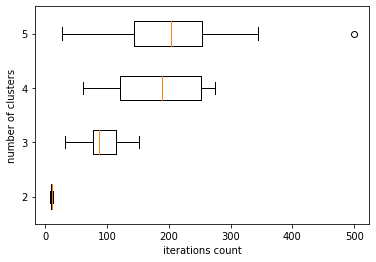

In [52]:
data = []
for k in [2,3,4,5]:
    with open(f"ringnorm{k}.pkl",'rb') as f:
        data.append(list(pkl.load(f)['iterations'].values()))
_  = plt.boxplot(data,vert=False,labels=['2','3','4','5'])

plt.xlabel('iterations count')
plt.ylabel('number of clusters')

In [4]:
posteriors,output_mus,output_covs,iterations = {},{},{},{}

for k in [2,3,4,5]:
    data = {}
    for e in range(20):
        print(f"k={k},e={e}")
        p,m,c,i = EM(X,k)
        posteriors[e] = p
        output_mus[e] = m
        output_covs[e] = c
        iterations[e] = i
    data['posteriors'] = posteriors
    data['output_mus'] = output_mus
    data['output_covs'] = output_covs
    data['iterations'] = iterations
    with open(f"ringnorm{k}.pkl",'wb') as f:
        pkl.dump(data,f)
        

k=2,e=0
k=2,e=1
k=2,e=2
k=2,e=3
k=2,e=4
k=2,e=5
k=2,e=6
k=2,e=7
k=2,e=8


KeyboardInterrupt: 

In [28]:
#creating a final array from the dataframe
posterior = pd.DataFrame(posterior)

# #check which point belongs to which cluster
# clusters = [posterior.iloc[0] < posterior.iloc[1]]
# #add a new row to the data frame with value 1 or 0 if point (represented by point) belongs to cluster 1 or 0 respectively
# posterior_assigned = posterior.append(clusters,ignore_index=True)
# cluster_df = pd.DataFrame()
# cluster_df['assigned1'] = posterior_assigned.T[2].astype(int)

# #check which point belongs to which cluster
# clusters = [posterior.iloc[0] > posterior.iloc[1]]
# #add a new row to the data frame with value 1 or 0 if point (represented by point) belongs to cluster 1 or 0 respectively
# posterior_assigned = posterior.append(clusters,ignore_index=True)
# cluster_df['assigned2'] = posterior_assigned.T[2].astype(int)

# #\s+ since dataset has one or more white spaces
# df = pd.read_csv("Dataset.data",sep='\s+',header=None)
# cluster_df['groundtruth'] = df[20].astype(int)

In [31]:
posterior.idxmax().to_dict()

{0: 3,
 1: 1,
 2: 1,
 3: 1,
 4: 2,
 5: 2,
 6: 2,
 7: 1,
 8: 2,
 9: 1,
 10: 2,
 11: 2,
 12: 1,
 13: 1,
 14: 3,
 15: 2,
 16: 2,
 17: 1,
 18: 1,
 19: 3,
 20: 1,
 21: 1,
 22: 1,
 23: 2,
 24: 0,
 25: 1,
 26: 2,
 27: 1,
 28: 1,
 29: 2,
 30: 1,
 31: 2,
 32: 2,
 33: 2,
 34: 2,
 35: 1,
 36: 2,
 37: 1,
 38: 1,
 39: 1,
 40: 2,
 41: 2,
 42: 3,
 43: 1,
 44: 2,
 45: 2,
 46: 1,
 47: 2,
 48: 2,
 49: 1,
 50: 2,
 51: 2,
 52: 1,
 53: 0,
 54: 1,
 55: 2,
 56: 1,
 57: 3,
 58: 1,
 59: 1,
 60: 1,
 61: 2,
 62: 2,
 63: 1,
 64: 2,
 65: 2,
 66: 1,
 67: 1,
 68: 3,
 69: 2,
 70: 1,
 71: 2,
 72: 1,
 73: 1,
 74: 2,
 75: 3,
 76: 1,
 77: 1,
 78: 2,
 79: 2,
 80: 2,
 81: 1,
 82: 1,
 83: 1,
 84: 1,
 85: 2,
 86: 1,
 87: 1,
 88: 1,
 89: 1,
 90: 1,
 91: 1,
 92: 2,
 93: 1,
 94: 2,
 95: 2,
 96: 1,
 97: 2,
 98: 2,
 99: 1,
 100: 1,
 101: 1,
 102: 1,
 103: 1,
 104: 1,
 105: 1,
 106: 1,
 107: 2,
 108: 2,
 109: 2,
 110: 1,
 111: 2,
 112: 2,
 113: 2,
 114: 2,
 115: 2,
 116: 2,
 117: 2,
 118: 1,
 119: 1,
 120: 2,
 121: 1,
 122: 1,
 12

In [25]:
cluster_df

,assigned1,assigned2,groundtruth
0,0,0,0
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,0
...,...,...,...
7395,0,0,1
7396,0,0,1
7397,0,0,0
7398,0,0,0


In [53]:
#\s+ since dataset has one or more white spaces
df = pd.read_csv("ionosphere.data",header=None)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 35 columns):
0     351 non-null int64
1     351 non-null int64
2     351 non-null float64
3     351 non-null float64
4     351 non-null float64
5     351 non-null float64
6     351 non-null float64
7     351 non-null float64
8     351 non-null float64
9     351 non-null float64
10    351 non-null float64
11    351 non-null float64
12    351 non-null float64
13    351 non-null float64
14    351 non-null float64
15    351 non-null float64
16    351 non-null float64
17    351 non-null float64
18    351 non-null float64
19    351 non-null float64
20    351 non-null float64
21    351 non-null float64
22    351 non-null float64
23    351 non-null float64
24    351 non-null float64
25    351 non-null float64
26    351 non-null float64
27    351 non-null float64
28    351 non-null float64
29    351 non-null float64
30    351 non-null float64
31    351 non-null float64
32    351 non-null float64
33    35

In [9]:
X = df.to_numpy()
X = X[:,:-1]

mean_g = [i/len(df[df[34]=='g']) for i in df[df[34]=='g'].sum(axis=0).to_list()[:-1]]
mean_b = [i/len(df[df[34]=='b']) for i in df[df[34]=='b'].sum(axis=0).to_list()[:-1]]

mus = np.array([mean_g,mean_g])

In [15]:
posterior,_,_,_ = EM(X,2)

2.5240066887761428
0.43292947978890517
0.17734976978254585
0.17391940761273283
0.24464198156930717
0.2719785854815305
0.10329096978171007
0.03780068282060572
0.0964200156894012
0.05365330942320483
0.048502346665501433
0.04448524046552727
0.05188157420099895
0.0026118928944935697


In [16]:
posterior = pd.DataFrame(posterior)
#check which point belongs to which cluster
clusters = [posterior.iloc[0] < posterior.iloc[1]]
#add a new row to the data frame with value 1 or 0 if point (represented by point) belongs to cluster 1 or 0 respectively
posterior_assigned = posterior.append(clusters,ignore_index=True)
cluster_df = pd.DataFrame()
cluster_df['assigned1'] = posterior_assigned.T[2].astype(int)

#check which point belongs to which cluster
clusters = [posterior.iloc[0] > posterior.iloc[1]]
#add a new row to the data frame with value 1 or 0 if point (represented by point) belongs to cluster 1 or 0 respectively
posterior_assigned = posterior.append(clusters,ignore_index=True)
cluster_df['assigned2'] = posterior_assigned.T[2].astype(int)

#\s+ since dataset has one or more white spaces
df = pd.read_csv("ionosphere.data",header=None)
cluster_df['groundtruth'] = df[20].astype(int)

In [17]:
cluster_df

,assigned1,assigned2,groundtruth
0,1,0,0
1,0,1,0
2,1,0,0
3,0,1,0
4,1,0,0
...,...,...,...
346,1,0,0
347,1,0,0
348,1,0,0
349,1,0,0


Text(0, 0.5, 'number of clusters')

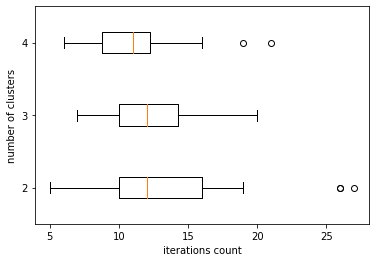

In [55]:
data = []
for k in [2,3,4]:
    with open(f"ionosphere{k}.pkl",'rb') as f:
        data.append(list(pkl.load(f)['iterations'].values()))
_  = plt.boxplot(data,vert=False,labels=['2','3','4'])

plt.xlabel('iterations count')
plt.ylabel('number of clusters')